In [1]:
#coding=utf8
"""
# Author : Jianbai(Gus) Ye
# created at Feb 2 2019
# pytorch implementation of HSIC bottleneck method
# reference : https://github.com/forin-xyz/Keras-HSIC-Bottleneck
"""
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals
import torch
from torch import nn, optim
import numpy as np
import sys
import matplotlib.pyplot as plt
from torchsummary import summary
# from collections import Iterable
import matplotlib.pyplot as plt

import torch.nn.functional as F
import time
from utils import *

In [2]:
torch.manual_seed(1)
batch_size = 256
train_loader, test_loader = load_data(batch_size=batch_size)

In [3]:
class Block(nn.Module):
    def __init__(self, inplane, outplane):
        super(Block, self).__init__()
        self.linear = nn.Linear(inplane, outplane)
        self.bn = nn.BatchNorm1d(outplane, affine=False)
        self.act = nn.GELU()
    def forward(self, x):
        x = self.linear(x)
        x = self.act(x)
        x = self.bn(x)
        return x
        
class Test_model(nn.Module):
    def __init__(self):
        super(Test_model, self).__init__()
        
        self.units = [784, 256, 128, 128]
#         self.module_list = [Block(self.units[i], self.units[i+1]).to(device) for i in range(len(self.units)-1)]
        self.module_list = nn.ModuleList( [Block(self.units[i], self.units[i+1]) for i in range(len(self.units)-1)])
        
        self.f3 = nn.Dropout(p=0.2)
        self.output_layer  = nn.Linear(self.units[-1], 10)        
        self.act2 = nn.ReLU()
        
    def forward(self, data):
        x = data
        output = []
        for module in self.module_list:
            x_ = module(x.detach())
            x = module(x)
            output.append(x_)
        x = self.f3(x)
        x_ = self.act2(self.output_layer(x.detach()))
        x = self.act2(self.output_layer(x))
        output.append(x_)
        return x, output
    
class HSICBottleneck:
    def __init__(self, model, batch_size, lambda_0, sigma, multi_sigma=None,lr=0.01):
        self.model      = model
        self.batch_size = batch_size
        self.lambda_0   = lambda_0
        self.sigma      = sigma
        self.extractor  = 'hsic'
        self.last_linear = "output_layer"
        self.lr         = lr
        self.multi_sigma = multi_sigma
        assert isinstance(self.multi_sigma, Iterable) if  multi_sigma is not None else True
        
        self.opt = optim.AdamW(self.model.parameters(), lr=0.001)
#         self.opt = optim.SGD(self.model.parameters(), lr=0.001)
        self.track_loss1 = []
        self.track_loss2 = []
        self.track_loss3 = []
        
        self.loss = "CE"
        if self.loss == "mse":
            self.output_criterion = nn.MSELoss()
        elif self.loss == "CE":
            self.output_criterion = nn.CrossEntropyLoss()
        
    def step(self, input_data, labels):
        
        one_hot_labels = F.one_hot(labels, num_classes=10)
        if self.loss == "mse":
            labels = F.one_hot(labels, num_classes=10).float()
        
        Kx  = kernel_matrix(input_data, self.sigma)
        Ky = kernel_matrix(one_hot_labels, self.sigma)
        
        total_loss1 = 0.
        total_loss2 = 0.
        total_loss3 = 0.
        y_pred, hidden_zs = self.model(input_data)
        
        kernel_list = list()
        for num, feature in enumerate(hidden_zs):
            kernel_list.append(kernel_matrix(feature, self.sigma))
        
        for num, feature in enumerate(kernel_list):
            if num == (len(hidden_zs)-1): 
                loss1 = norm_HSIC(feature, kernel_list[num-1], self.batch_size, device)
#                 loss2 = - self.lambda_0*norm_HSIC(feature, kernel_list[num+1], self.batch_size, device)
                total_loss3 += self.output_criterion(feature, labels)
            elif num == 0:
                loss1 = norm_HSIC(feature, Kx, self.batch_size, device)
                loss2 = - self.lambda_0*norm_HSIC(feature, Ky, self.batch_size, device)
            else:
                loss1 = norm_HSIC(feature, kernel_list[num-1], self.batch_size, device)
                loss2 = - self.lambda_0*norm_HSIC(feature, Ky, self.batch_size, device)
            total_loss1 += loss1
            total_loss2 += loss2
                
        total_loss = total_loss1 + total_loss2 + total_loss3
        self.opt.zero_grad()
        total_loss.backward()
        self.opt.step()
        
        self.track_loss1.append(total_loss1.item())
        self.track_loss2.append(total_loss2.item())
        self.track_loss3.append(total_loss3.item())
                
        return total_loss1.item(), total_loss2.item(), total_loss3.item()
    
    def tune_output(self, input_data, labels):
        
        if self.loss == "mse":
            one_hot_labels = F.one_hot(labels, num_classes=10)
            labels = F.one_hot(labels, num_classes=10).float()
        
        y_pred, hidden_zs = self.model(input_data)
        total_loss = self.output_criterion(hidden_zs[-1], labels)
        self.opt.zero_grad()
        total_loss.backward()
        self.opt.step()
    
        return total_loss.item()
    
def show_result():
    model.eval()
    with torch.no_grad():
        counts, correct, counts2, correct2 = 0, 0, 0, 0        
        for batch_idx, (data, target) in enumerate(train_loader): 
            output = hsic.model.forward(data.view(batch_size, -1).to(device))[0].cpu()
            pred = output.argmax(dim=1, keepdim=True)
            correct += (pred[:,0] == target).float().sum()
            counts += len(pred)
        for batch_idx, (data, target) in enumerate(test_loader): 
            output = hsic.model.forward(data.view(batch_size, -1).to(device))[0].cpu()
            pred = output.argmax(dim=1, keepdim=True)
            correct2 += (pred[:,0] == target).float().sum()
            counts2 += len(pred)
        print("Training  ACC: {:.2f} \t Testing ACC: {:.2f}".format(correct/counts, correct2/counts2))

In [7]:
device = "cuda:0"
model = Test_model()
model.to(device)
model.train()
HSIC_epochs = 100
lambda_0 = 500

hsic = HSICBottleneck(model, batch_size=batch_size, lambda_0=lambda_0, sigma=10.)

for epoch in range(HSIC_epochs):
    model.train()
    start = time.time()
    total_loss1, total_loss2, total_loss3, total_loss_tune = 0, 0, 0, 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(batch_size, -1)
        loss1, loss2, loss3 = hsic.step(data.view(batch_size, -1).to(device), target.to(device))
        total_loss_tune += hsic.tune_output(data.view(batch_size, -1).to(device), target.to(device))
        total_loss1 += loss1
        total_loss2 += loss2
        total_loss3 += loss3
    if epoch in range(0, 100, 10):
        print("===============================")
        print("EPOCH %d" % epoch)
        model.eval()
        show_result()
        sys.stdout.write("{:.3f}, {:.3f}, {:.3f}, {:.3f}".format(total_loss1/(batch_idx+1), 
                                                                 total_loss2/lambda_0*100/(batch_idx+1), 
                                                                 total_loss3/(batch_idx+1),
                                                                 total_loss_tune/(batch_idx+1)))
        sys.stdout.flush()
        sys.stdout.write('\n')
        print("{:.2f}".format(time.time()-start))

EPOCH 0
Training  ACC: 0.91 	 Testing ACC: 0.91
0.011, -0.054, 5.549, 0.772
10.17
EPOCH 10
Training  ACC: 0.95 	 Testing ACC: 0.94
0.009, -0.054, 5.556, 0.233
10.23
EPOCH 20
Training  ACC: 0.95 	 Testing ACC: 0.95
0.008, -0.054, 5.556, 0.203
10.17
EPOCH 30
Training  ACC: 0.96 	 Testing ACC: 0.95
0.007, -0.054, 5.554, 0.185
10.96
EPOCH 40
Training  ACC: 0.96 	 Testing ACC: 0.95
0.007, -0.054, 5.559, 0.173
10.86
EPOCH 50
Training  ACC: 0.96 	 Testing ACC: 0.95
0.007, -0.054, 5.554, 0.178
11.02
EPOCH 60
Training  ACC: 0.96 	 Testing ACC: 0.95
0.007, -0.054, 5.557, 0.174
11.00
EPOCH 70
Training  ACC: 0.96 	 Testing ACC: 0.95
0.007, -0.054, 5.559, 0.164
10.74
EPOCH 80
Training  ACC: 0.96 	 Testing ACC: 0.96
0.007, -0.054, 5.557, 0.160
10.82
EPOCH 90
Training  ACC: 0.96 	 Testing ACC: 0.95
0.007, -0.054, 5.557, 0.161
11.02


0


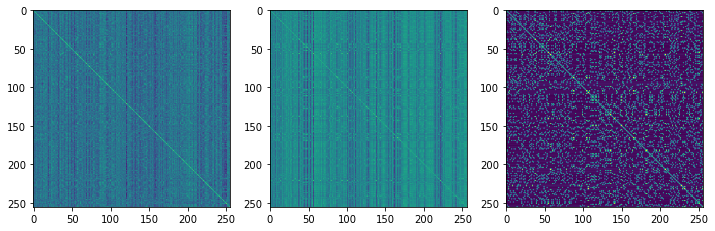

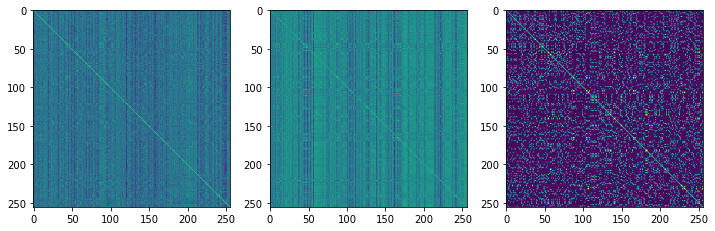

1


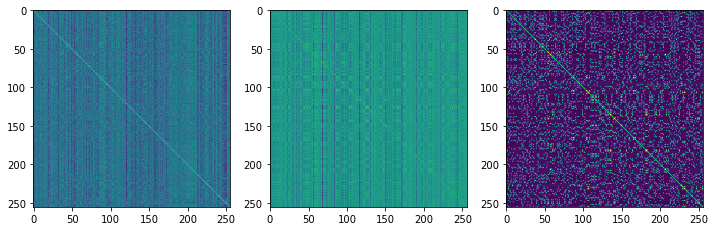

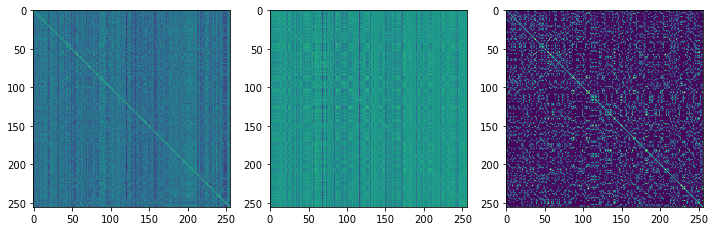

2


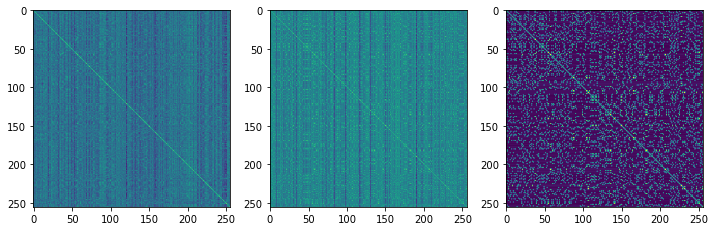

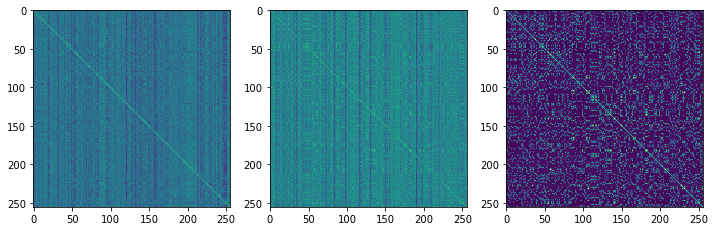

3


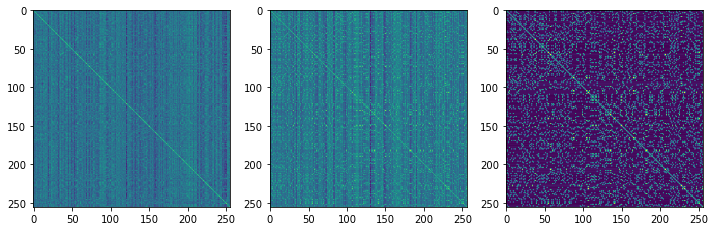

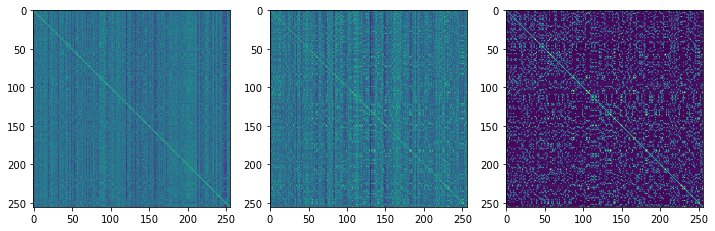

In [8]:
from sklearn.decomposition import PCA 
output, hidden = hsic.model(data.view(batch_size, -1).to(device))
t = F.one_hot(target, num_classes=10).float()

for i, z in enumerate(hidden):
    print(i)
    z_ = z.detach().cpu()
    fig, axes = plt.subplots(1,3,figsize=(12,4))
    axes[0].imshow(mean(kernel_matrix(data.view(batch_size, -1), 100)))
    axes[1].imshow(mean(kernel_matrix(z_, 100)))
    axes[2].imshow(mean(kernel_matrix(t, 100)))
    plt.pause(0.1)
    
    fig, axes = plt.subplots(1,3,figsize=(12,4))
    axes[0].imshow(mean(kernel_student(data.view(batch_size, -1), 100)))
    axes[1].imshow(mean(kernel_student(z_, 100)))
    axes[2].imshow(mean(kernel_student(t, 100)))
    plt.pause(0.1)

In [6]:
target

tensor([4, 8, 2, 9, 9, 5, 2, 4, 0, 0, 0, 5, 6, 2, 8, 3, 2, 8, 9, 8, 4, 9, 4, 8,
        8, 8, 7, 3, 9, 5, 7, 4, 6, 0, 4, 7, 5, 4, 7, 0, 5, 2, 8, 6, 9, 2, 1, 7,
        6, 1, 2, 4, 5, 5, 2, 2, 7, 3, 0, 1, 7, 9, 2, 7, 7, 9, 1, 0, 8, 3, 9, 4,
        2, 5, 4, 5, 2, 5, 0, 0, 1, 2, 6, 0, 4, 6, 1, 6, 0, 5, 2, 9, 1, 4, 1, 5,
        6, 8, 1, 4, 4, 8, 5, 1, 2, 4, 2, 7, 0, 6, 6, 8, 3, 0, 9, 6, 6, 6, 8, 3,
        2, 7, 2, 4, 0, 1, 7, 5, 8, 8, 2, 6, 1, 8, 0, 1, 1, 2, 8, 0, 6, 5, 0, 7,
        5, 9, 6, 4, 6, 7, 5, 1, 8, 1, 0, 7, 6, 4, 4, 6, 0, 0, 8, 2, 4, 6, 6, 9,
        6, 6, 2, 0, 6, 4, 8, 1, 3, 4, 0, 6, 8, 6, 3, 0, 8, 7, 4, 1, 4, 9, 8, 0,
        0, 9, 0, 0, 2, 0, 2, 0, 0, 7, 0, 7, 8, 7, 2, 2, 6, 3, 0, 7, 4, 3, 4, 6,
        7, 1, 9, 9, 9, 3, 6, 7, 9, 3, 7, 5, 3, 7, 7, 5, 0, 5, 7, 9, 0, 7, 1, 3,
        1, 6, 5, 3, 3, 4, 9, 0, 2, 0, 2, 1, 8, 4, 9, 0])